# Toy Model

In [120]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg
from sklearn.decomposition import PCA

class Toy_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_evecs #Complete space
        self.k_arr   = np.linspace(0,100, n_k)
        self.k_mean  = np.mean(self.k_arr)
        self.wc_arr  = np.linspace(0.25, 0.3, n_train)
        self.h_arr   = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self.get_theory(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
            np.savetxt('toy_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('toy_grid.txt')
        
        self.grid_mean = np.mean(self.grid, axis=0)
        self.residues = self.grid-self.grid_mean
        self.evecs = None
        self.hand_evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        return 
            
    
    def get_evecs(self, manual = False):
        if self.evecs is None:
            if not manual:
                print('Manual:', manual)
                pca = PCA(n_components=self.n_evecs) 
                self.evecs = pca.fit_transform(np.transpose(self.residues))
                #w1 = np.array(np.ones(len(self.k_arr)))
                #self.evecs = np.insert(np.transpose(self.evecs), 0, [w1], axis=0)
                self.evecs = np.transpose(self.evecs)
            else: 
                print('Manual:', manual)
                cov = np.cov(np.transpose(self.residues))
                self.evals, self.evecs = linalg.eig(cov)
                #evecs right hand make left hand
                self.evecs = np.transpose(self.evecs)
                self.evecs = self.evecs[:self.n_evecs]#*self.evals
                print(self.evals)
                
        return self.evecs
       
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    f_k_ij = self.get_theory(self.wc_arr[i], self.h_arr[j]) - self.grid_mean
                    w_ij = self._get_weigths(f_k_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w = 0
            for w_i in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, w_i, kind='cubic')
                                                #interp2d( x(column coor), y(row coor), w_i, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, target):
        M = np.transpose(self.evecs)
        #M = self.evecs
        return np.linalg.lstsq(M, target, rcond=None)[0]
        
    def get_theory(self, wc, h):
        return h + wc*(self.k_arr-self.k_mean/2)
        
    def _get_predict(self, weigths , evecs):
        M = np.transpose(self.evecs)
        #M = self.evecs
        return self.grid_mean + np.sum(M*weigths, axis=1) 
    
    def get_emulated_f(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(len(self.evecs)): # n_evecs
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        f_k = self._get_predict(w_vec, self.evecs)
        return self.k_arr, np.array(f_k)
    
    

In [121]:
toy = Toy_emulator(10, 10, 5, new= True)

In [122]:
evecs = toy.get_evecs(manual = True)

Manual: True
[ 4.26284839e+00  5.69008863e-02 -6.14316306e-16  5.35123458e-16
  2.35698171e-16  1.17711470e-16 -1.70319940e-16 -7.58292908e-17
 -2.14778244e-17 -4.50399550e-18]


In [123]:
evecs

array([[ 0.18907104,  0.10313134,  0.01719164, -0.06874806, -0.15468777,
        -0.24062747, -0.32656717, -0.41250687, -0.49844657, -0.58438627],
       [ 0.55651297,  0.48769742,  0.41888187,  0.35006632,  0.28125077,
         0.21243523,  0.14361968,  0.07480413,  0.00598858, -0.06282697],
       [ 0.17702774,  0.18256157,  0.02621167, -0.09232787, -0.23958489,
        -0.31715878, -0.15879426,  0.39375198, -0.52781836,  0.55613119],
       [-0.11657548, -0.03301882, -0.06532866, -0.01131244,  0.05915101,
        -0.17669114,  0.32438921,  0.72702648, -0.17770599, -0.52993417],
       [-0.06144387,  0.28597556,  0.23871473, -0.13035969, -0.11249883,
        -0.54955213, -0.36184593,  0.37068079,  0.4812243 , -0.16089492]])

In [124]:
w_arr = toy.get_w_arr()

In [125]:
toy.get_w_emulator()

{'w_0': <scipy.interpolate.interpolate.interp2d at 0x7fc5a7cce8e0>,
 'w_1': <scipy.interpolate.interpolate.interp2d at 0x7fc5a7cced00>,
 'w_2': <scipy.interpolate.interpolate.interp2d at 0x7fc5a7ccec40>,
 'w_3': <scipy.interpolate.interpolate.interp2d at 0x7fc5a7cce2b0>,
 'w_4': <scipy.interpolate.interpolate.interp2d at 0x7fc5a7ccedc0>}

In [126]:
k_arr, emulated = toy.get_emulated_f(0.27,0.67 )
theory = toy.get_theory(0.27, 0.67)

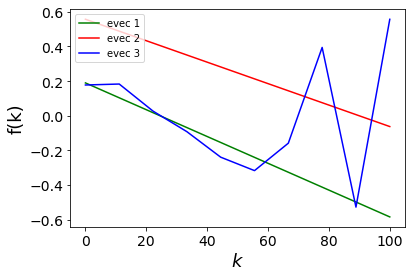

In [127]:
plt.plot( k_arr, evecs[0] , 'g-', label = 'evec 1' )
plt.plot( k_arr, evecs[1] , 'r-', label = 'evec 2' )
plt.plot( k_arr, evecs[2] , 'b-', label = 'evec 3' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

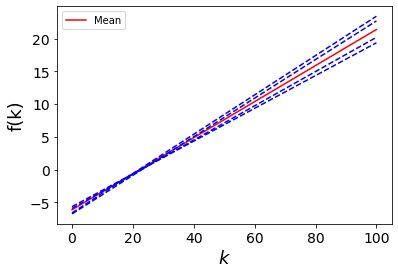

In [128]:
plt.plot( k_arr, toy.grid_mean*np.ones(len(k_arr)) , 'r-', label = 'Mean' )
plt.plot( k_arr, toy.grid[0] , 'b--' )
plt.plot( k_arr, toy.grid[20] , 'b--' )
plt.plot( k_arr, toy.grid[-20] , 'b--' )
plt.plot( k_arr, toy.grid[-1] , 'b--' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

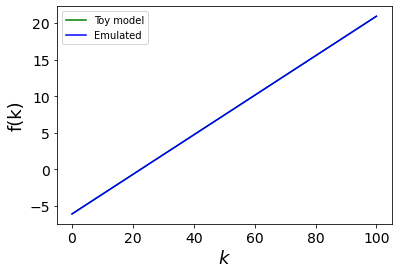

In [129]:
plt.plot(k_arr, theory , 'g-', label = 'Toy model' )
plt.plot(k_arr, emulated , 'b-', label = 'Emulated' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

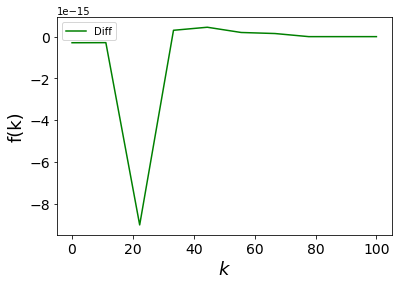

In [130]:
plt.plot(k_arr, np.abs(theory-emulated)/ theory, 'g-', label = 'Diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()